In [93]:
# Initial setup

# This is script may only work with sentinelhub.__version__ >= '3.4.0'
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import rasterio
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
import pandas as pd
from datetime import datetime, timedelta

In [94]:
# Credentials
config = SHConfig()
config.sh_client_id = '51de89e2-5b0c-400b-aa2c-d8c88b8c5a93'
config.sh_client_secret = 'U0DFA)6>X_{ermI?D[+*?!;rdy}OR0:t03j,5KKP'

In [95]:
# Class definitions
class Fire:
    def __init__(self, fire_id, fire_name, fire_area, ignition_date, minx, miny, maxx, maxy):
        self.fire_id = fire_id
        self.fire_name = fire_name
        self.fire_area = fire_area
        self.ignition_date = ignition_date
        self.minx = minx
        self.miny = miny
        self.maxx = maxx
        self.maxy = maxy

    def get_bbox(self):
        return [self.minx, self.miny, self.maxx, self.maxy]


class BoundingBox:
    def __init__(self, minx, miny, maxx, maxy, index, date=None):
        self.minx = minx
        self.miny = miny
        self.maxx = maxx
        self.maxy = maxy
        self.bbox_idx = index
        self.date = date
        

def bbox_collision(bbox1, bbox2):
    # Each bbox is a list like [min_lon, min_lat, max_lon, max_lat]
    return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


def generate_bboxes(region_bbox, lon_diff, lat_diff):
    min_lon, min_lat, max_lon, max_lat = region_bbox
    boxes = []

    current_min_lon = min_lon
    while current_min_lon < max_lon:
        current_max_lon = current_min_lon + lon_diff
        current_min_lat = min_lat
        while current_min_lat < max_lat:
            current_max_lat = current_min_lat + lat_diff
            box = [current_min_lon, current_min_lat, current_max_lon, current_max_lat]
            boxes.append(box)
            current_min_lat += lat_diff
        current_min_lon += lon_diff

    return boxes

In [96]:
# 1. Read the CSV File
file_path = '/Users/taylortang/Life-at-UniMelb/Semester_4/COMP90055_Research/DataPrep/all_fire_from_2016_greater_20000ha.csv'
data = pd.read_csv(file_path)

# Filter rows by date
start_date = '2019-09-01'  # Black Summer start
end_date = '2020-05-31'    # Black Summer end
filtered_data = data[(data['ignition_date'] >= start_date) & (data['ignition_date'] <= end_date)]

In [97]:
all_fires = []

# Create a list of Fire objects
for index, row in filtered_data.iterrows():
    fire = Fire(row['fid'], row['fire_name'], row['area_ha'], row['ignition_date'], row['Min_X'], row['Min_Y'], row['Max_X'], row['Max_Y'])
    all_fires.append(fire)

print("total number of fire events: ", len(all_fires))

# Generate bboxes
combined_bbox = [141.022868, -38.987535, 153.580241, -29.030169]
center_lon = (combined_bbox[0] + combined_bbox[2]) / 2
center_lat = (combined_bbox[1] + combined_bbox[3]) / 2
square_size = max(combined_bbox[2] - combined_bbox[0], combined_bbox[3] - combined_bbox[1])
square_bbox = [
    center_lon - square_size / 2,
    center_lat - square_size / 2,
    center_lon + square_size / 2,
    center_lat + square_size / 2
]

lon_diff = (square_bbox[2] - square_bbox[0]) / 14
lat_diff = (square_bbox[3] - square_bbox[1]) / 14

all_bboxes = generate_bboxes(square_bbox, lon_diff, lat_diff)

print("total number of blocks: ", len(all_bboxes))

# For every 10 days, check which fires have been ignited and if they collide with our bboxes
current_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

def bbox_to_unique_id(bbox_obj):
    """ Convert BoundingBox object to a unique identifier string """
    return f"{bbox_obj.minx}_{bbox_obj.miny}_{bbox_obj.maxx}_{bbox_obj.maxy}_{bbox_obj.bbox_idx}_{bbox_obj.date}"

resulting_bboxes = []
seen_bboxes = set()  # To track unique bounding boxes

while current_date <= end_date_obj:
    for fire in all_fires:
        fire_ignition_date = datetime.strptime(fire.ignition_date, '%Y/%m/%d %H:%M:%S+00')

        if fire_ignition_date <= current_date and fire_ignition_date > (current_date - timedelta(days=10)):
            for index, bbox in enumerate(all_bboxes):
                if bbox_collision(fire.get_bbox(), bbox):
                    # intervals = [-20, -10, 0, 10, 20]
                    # S2
                    # intervals = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
                    
                    # S3
                    intervals = []
                    for i in range(-5, 15):
                        intervals.append(i)

                    for interval in intervals:
                        new_bbox = BoundingBox(bbox[0], bbox[1], bbox[2], bbox[3], index, current_date + timedelta(days=interval))
                        unique_id = bbox_to_unique_id(new_bbox)
                        if unique_id not in seen_bboxes:
                            resulting_bboxes.append(new_bbox)
                            seen_bboxes.add(unique_id)
    # S2
    # current_date += timedelta(days=10)

    # S3
    current_date += timedelta(days=5)

total number of fire events:  153
total number of blocks:  196


In [98]:
print("total number of bbox with time: ", len(resulting_bboxes))

total number of bbox with time:  1630


In [99]:
# sort resulting_bboxes by each boundingbox object bbox index
resulting_bboxes.sort(key=lambda x: x.bbox_idx)

# for bbox in resulting_bboxes:
#     print(bbox.date, bbox.bbox_idx)

In [100]:
'''
Sentinel-2 bands                Sentinel-2A	                                    Sentinel-2B	
                                Central wavelength (nm)	    Bandwidth (nm)	    Central wavelength (nm)	Bandwidth (nm)	    Spatial resolution (m)
Band 1 – Coastal aerosol	    442.7	                    21	                442.2	                21	                60
Band 2 – Blue	                492.4	                    66	                492.1	                66	                10
Band 3 – Green	                559.8	                    36	                559.0	                36	                10
Band 4 – Red	                664.6	                    31	                664.9	                31	                10
Band 5 – Vegetation red edge	704.1	                    15	                703.8	                16	                20
Band 6 – Vegetation red edge	740.5	                    15	                739.1	                15	                20
Band 7 – Vegetation red edge	782.8	                    20	                779.7	                20	                20
Band 8 – NIR	                832.8	                    106	                832.9	                106	                10
Band 8A – Narrow NIR	        864.7	                    21	                864.0	                22	                20
Band 9 – Water vapour	        945.1	                    20	                943.2	                21	                60
Band 10 – SWIR – Cirrus	        1373.5	                    31	                1376.9	                30	                60
Band 11 – SWIR	                1613.7	                    91	                1610.4	                94	                20
Band 12 – SWIR	                2202.4	                    175	                2185.7	                185	                20
'''

# TRUE color, B*G*R
s2_evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2*sample.B04, 2*sample.B03, 2*sample.B02];
    }
"""

# TRUE color with Scene Classification Layer, B*G*R + SLC, 
s2_evalscript_true_color_SLC = """
//VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "SCL"]  // Add the SCL band
            }],
            output: {
                bands: 4  // We're now returning 4 bands: R, G, B, and SCL
            }
        };
    }

    function evaluatePixel(sample) {
        return [2*sample.B04, 2*sample.B03, 2*sample.B02, sample.SCL];
    }
"""

# FALSE color, SWIR*NIR*Red
s2_evalscript_SWIR = """

    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B12", "B8A", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2*sample.B12, 2*sample.B8A, 2*sample.B04];
    }
"""

# TRUE color, B*G*R*NIR*SWIR*SWIR
s2_evalscript_Burned = """

    //VERSION=3

    function setup() {
        return {
            input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
            output: { bands: 4 }
        };
    }

    function evaluatePixel(samples) {
        var NDWI=index(samples.B03, samples.B08); 
        var NDVI=index(samples.B08, samples.B04);
        var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

        if((INDEX>0.1)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
            return[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask]
        }
        else {
        return [1, 0, 0, samples.dataMask]
        }
    }
"""

s2_evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""


s3_evalscript_true_color = """

    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["S3", "S2", "S1"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5*sample.S3, 2.5*sample.S2, 2.5*sample.S1];
    }
"""

# S3 SLSTR - 500m resolution
s3_evalscript_slstr_s1tos6_bands = """

    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["S1", "S2", "S3", "S4", "S5", "S6"]
            }],
            output: {
                bands: 6
            }
        };
    }

    function evaluatePixel(sample) {
        return [
            sample.S1,
            sample.S2,
            sample.S3,
            sample.S4,
            sample.S5,
            sample.S6
        ];
    }
"""

s3_evalscript_slstr_s7tof2_bands = """

    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["S7", "S8", "S9", "F1", "F2"]
            }],
            output: {
                bands: 5
            }
        };
    }

    function evaluatePixel(sample) {
        return [
            sample.S7,
            sample.S8,
            sample.S9,
            sample.F1,
            sample.F2
        ];
    }
"""

s3_evalscript_olci_all_bands = """

    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B10", "B11", "B12", "B13", "B14", "B15", "B16", "B17", "B18", "B19", "B20", "B21"]
            }],
            output: {
                bands: 21
            }
        };
    }

    function evaluatePixel(sample) {
        return [
            sample.B01,
            sample.B02,
            sample.B03,
            sample.B04,
            sample.B05,
            sample.B06,
            sample.B07,
            sample.B08,
            sample.B09,
            sample.B10,
            sample.B11,
            sample.B12,
            sample.B13,
            sample.B14,
            sample.B15,
            sample.B16,
            sample.B17,
            sample.B18,
            sample.B19,
            sample.B20,
            sample.B21
        ];
    }
"""

    

In [101]:
# query single image
def query_image(bbox_coords, date_from, date_to, evalscript, size, sat, LEAST_CC=False):
    bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)

    satellite = dict()
    satellite['S2L1C'] = DataCollection.SENTINEL2_L1C
    satellite['S2L2A'] = DataCollection.SENTINEL2_L2A
    satellite['S3OLCI'] = DataCollection.SENTINEL3_OLCI
    satellite['S3SLSTR'] = DataCollection.SENTINEL3_SLSTR

    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=satellite[sat],         
                time_interval=(date_from, date_to),
                mosaicking_order=MosaickingOrder.LEAST_CC if LEAST_CC else MosaickingOrder.MOST_RECENT,
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG),
        ],
        bbox=bbox,
        size=[size, size],
        config=config
    )

    response = request.get_data()
    return response

def apply_cloud_mask(image, scl_band):
    """
    Apply cloud mask based on the Scene Classification Layer (SCL).
    
    :param image: An ndarray with the RGB values.
    :param scl_band: The SCL band from the image.
    :return: Cloud-masked image.
    """
    
    CLOUD_LABELS = [8, 9, 10]  # 8=Cloud medium prob., 9=Cloud high prob., 10=Thin Cirrus
    
    mask = np.isin(scl_band, CLOUD_LABELS)
    image[mask, :] = 0  # Set the RGB values to 0 where there are clouds

    return image

In [102]:
# Define directories
current_dir = os.getcwd()

# evalscript to use
evalscripts = [
    # s2_evalscript_true_color, 
    # s2_evalscript_SWIR, 
    # s2_evalscript_Burned
    # s2_evalscript_all_bands

    # s3 slstr
    # s3_evalscript_slstr_s1tos6_bands,
    # s3_evalscript_slstr_s7tof2_bands

    # s3 olci
    s3_evalscript_olci_all_bands
]

# output directories
output_dirs = [
    # os.path.join(current_dir, 'satellite_images', 'true_color'),
    # os.path.join(current_dir, 'satellite_images', 'SWIR'),
    # os.path.join(current_dir, 'satellite_images', 'Burned')

    # s3 slstr
    # os.path.join(current_dir, 'satellite_images', 's3_slstr_s1tos7_bands'),
    # os.path.join(current_dir, 'satellite_images', 's3_slstr_s7tof2_bands')

    # s3 olci
    os.path.join(current_dir, 'satellite_images', 's3_olci_all_bands')
]

# Ensure directories exist
for output_dir in output_dirs:
    os.makedirs(output_dir, exist_ok=True)

# satellite
satellite = dict()
satellite['S2L1C'] = DataCollection.SENTINEL2_L1C
satellite['S2L2A'] = DataCollection.SENTINEL2_L2A
satellite['S3OLCI'] = DataCollection.SENTINEL3_OLCI
satellite['S3SLSTR'] = DataCollection.SENTINEL3_SLSTR

size = 2048
# sat = 'S2L1C'
sat = 'S3OLCI'
LEAST_CC = False

# Query for each evalscript
for index, evalscript in enumerate(evalscripts):
    
    n = 0
    req_list = []
    bbox_mapping = []

    for bbox_obj in tqdm(resulting_bboxes, desc="Processing bounding boxes", unit="bbox"):

        # n += 1
        # if n > 8:
        #     break

        # Get bbox info
        bbox_coords = [bbox_obj.minx, bbox_obj.miny, bbox_obj.maxx, bbox_obj.maxy]
        bbox_idx = bbox_obj.bbox_idx
        bbox_date_from = bbox_obj.date.strftime('%Y-%m-%d')
        # bbox_date_to = (bbox_obj.date + timedelta(days=5)).strftime('%Y-%m-%d')
        bbox_date_to = (bbox_obj.date + timedelta(days=1)).strftime('%Y-%m-%d')

        bbox_mapping.append({
            "bbox_idx": bbox_idx,
            "date_from": bbox_date_from,
            "date_to": bbox_date_to
        })

        # create bbox
        bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)

        # build request
        request = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=satellite[sat],         
                    time_interval=(bbox_date_from, bbox_date_to),
                    mosaicking_order=MosaickingOrder.LEAST_CC if LEAST_CC else MosaickingOrder.MOST_RECENT,
                ),
            ],
            responses=[
                # SentinelHubRequest.output_response('default', MimeType.PNG),
                SentinelHubRequest.output_response("default", MimeType.TIFF)
            ],
            bbox=bbox,
            size=[size, size],
            config=config
        )

        # add request to list
        req_list.append(request)

    # prepare list
    request_list = [reg.download_list[0] for reg in req_list]

    # # download data
    # data = SentinelHubDownloadClient(config=config).download(
    #     request_list,
    #     max_threads=4
    # )


    download_client = SentinelHubDownloadClient(config=config)

    idx = 0
    for request in tqdm(request_list, desc="Downloading data", unit="request"):
        
        image_data = download_client.download([request], max_threads=1)[0]
        meta = bbox_mapping[idx]
        bbox_dir = os.path.join(output_dirs[index], f"bbox_{meta['bbox_idx']}")
        os.makedirs(bbox_dir, exist_ok=True)
        output_file = os.path.join(bbox_dir, f"{meta['date_from']}_to_{meta['date_to']}.tiff")

        width=image_data.shape[1],
        height=image_data.shape[0],
        count=image_data.shape[2]


        with rasterio.open(output_file, 'w', driver='GTiff', width=image_data.shape[1], height=image_data.shape[0], count=image_data.shape[2], dtype=image_data.dtype) as dst:
            for band_id in range(1, image_data.shape[2] + 1):
                dst.write(image_data[:, :, band_id - 1], band_id)

        idx += 1

        if idx > 10:
            break



Processing bounding boxes: 100%|██████████| 1630/1630 [00:00<00:00, 7106.29bbox/s]
  dataset = writer(


In [111]:
import numpy as np

def stitch_images(images, rows, cols):
    # Check that the number of images matches rows x cols
    if len(images) != rows * cols:
        raise ValueError(f"Number of images ({len(images)}) does not match rows x cols ({rows} x {cols}).")

    # Assuming all images are of the same size
    img_height, img_width, channels = images[0].shape

    # Check if all images have the same shape
    if not all([img.shape == (img_height, img_width, channels) for img in images]):
        raise ValueError("Not all images have the same shape.")
    
    # Create an empty canvas
    stitched_img = np.zeros((img_height * rows, img_width * cols, channels), dtype=np.uint8)
    
    for row in range(rows):
        for col in range(cols):
            # Adjusted index retrieval:
            idx = col * rows + (rows - 1 - row)
            stitched_img[row * img_height: (row + 1) * img_height, col * img_width: (col + 1) * img_width] = images[idx]

    return stitched_img


In [112]:
import cv2

# Load each saved image and append it to the list
images_list = []

for idx, bbox in enumerate(result_boxes):
    if bbox is None:
        # For None bounding boxes, append a black image
        black_img = np.zeros((512, 512, 3), dtype=np.uint8)
        images_list.append(black_img)
    else:
        img_path = os.path.join(os.getcwd(), 'images', f'bbox_{idx}_{date_from.replace("-", "")}_{date_to.replace("-", "")}_true_color.jpeg')
        img = plt.imread(img_path)
        
        # Check and resize if needed using cv2
        if img.shape[0] != 512 or img.shape[1] != 512:
            print(f"Resizing image at index {idx} from {img.shape} to (512, 512, 3)")
            img = cv2.resize(img, (512, 512))
        
        images_list.append(img)

print(len(images_list))

Resizing image at index 46 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 47 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 57 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 58 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 59 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 68 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 69 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 70 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 79 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 80 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 81 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 82 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 83 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 91 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 92 from (2560, 2560, 3) to (512, 512, 3)
Resizing image at index 9

In [113]:
# Now, stitch the images together
stitched_image = stitch_images(images_list, 11, 11)

# Save the stitched image
output_dir = os.path.join(os.getcwd(), 'images')

output_file_whole = os.path.join(output_dir, f"whole_{date_from.replace('-', '')}_{date_to.replace('-', '')}_true_color.jpeg")
plt.imsave(output_file_whole, stitched_image)

Width: 2048
Height: 2048
Number of Bands: 21
Data Type: uint8
Coordinate Reference System (CRS): None
Transform: | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|


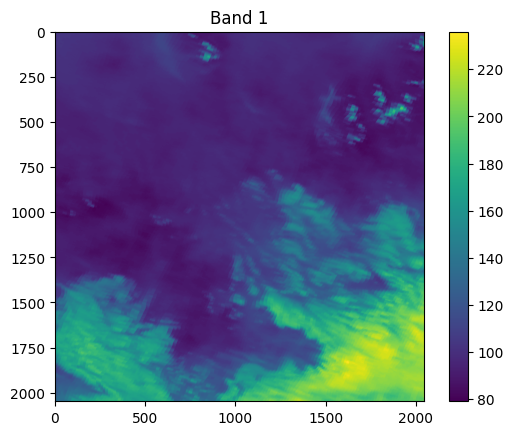

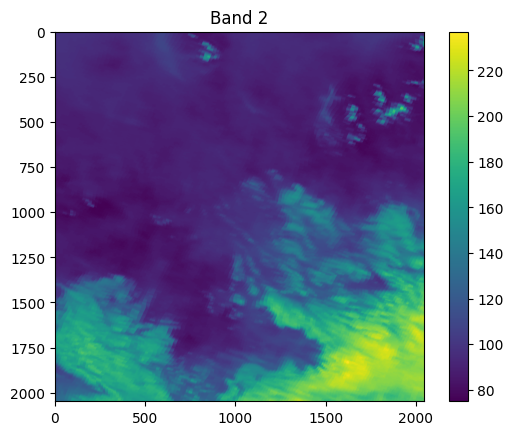

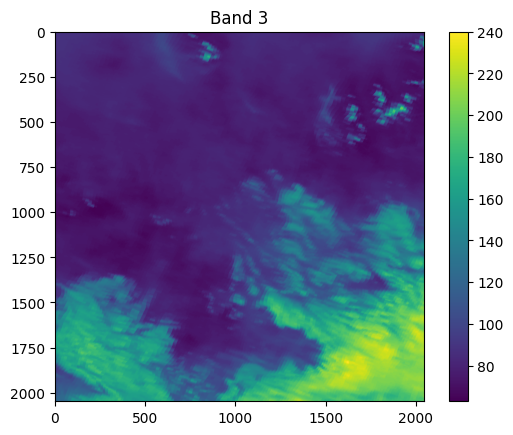

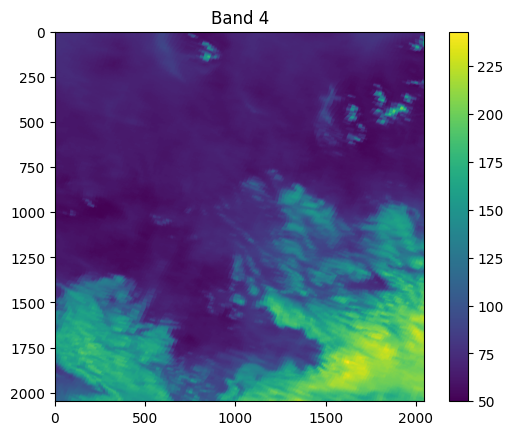

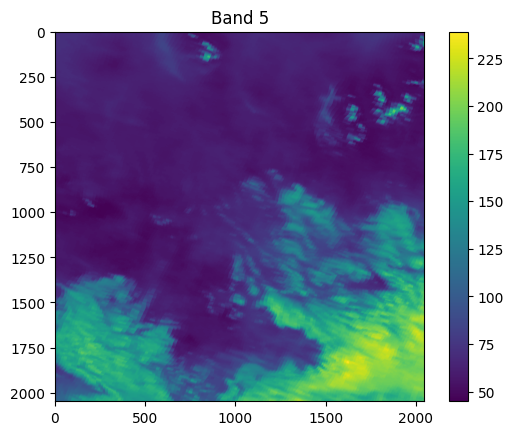

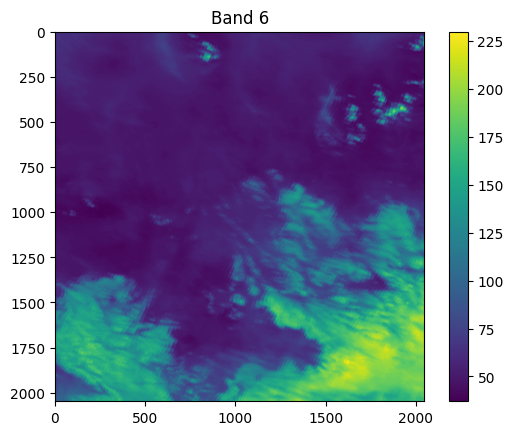

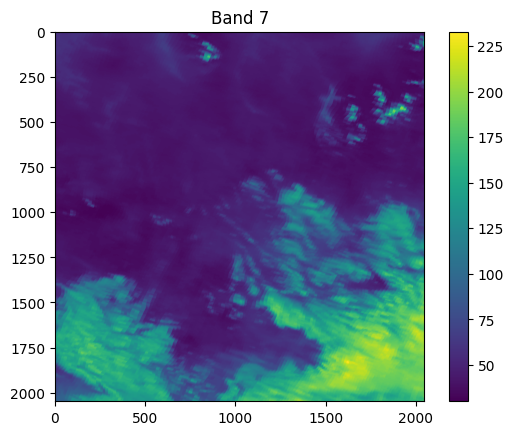

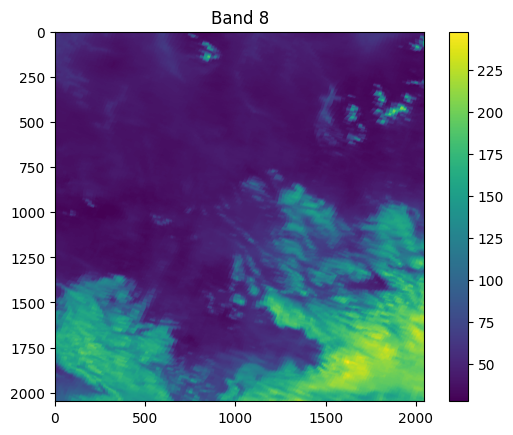

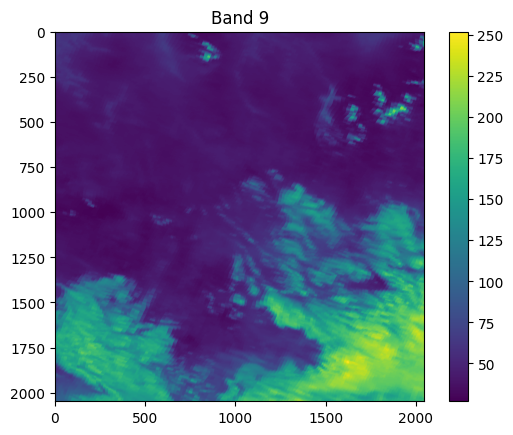

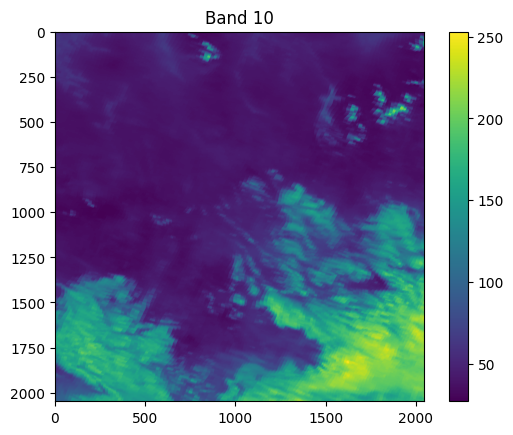

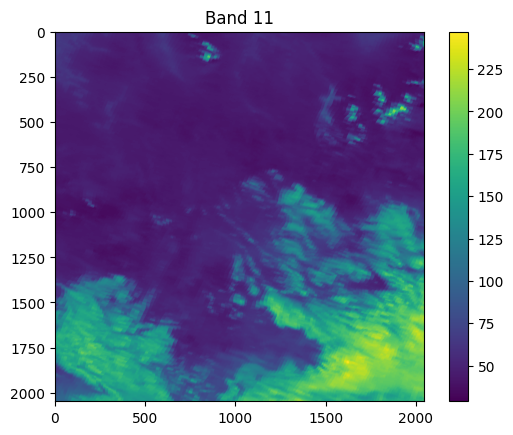

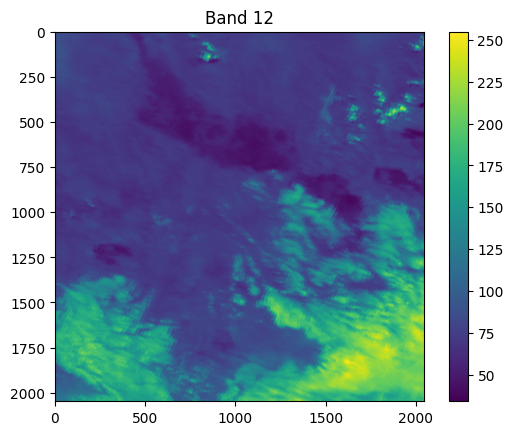

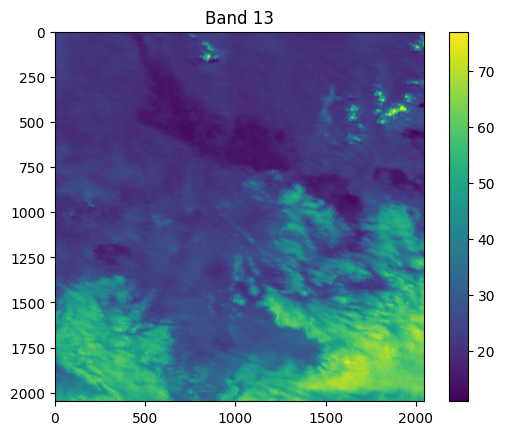

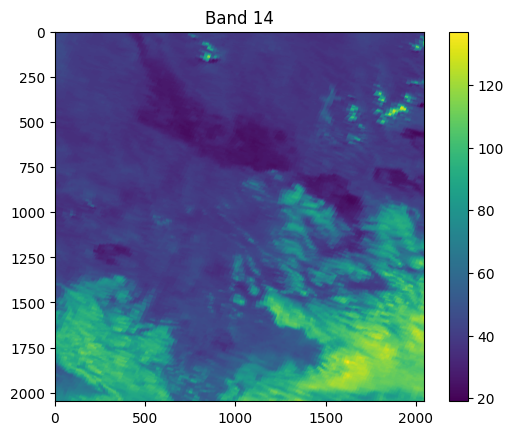

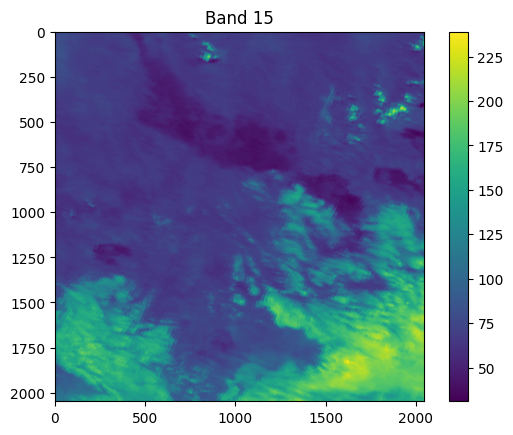

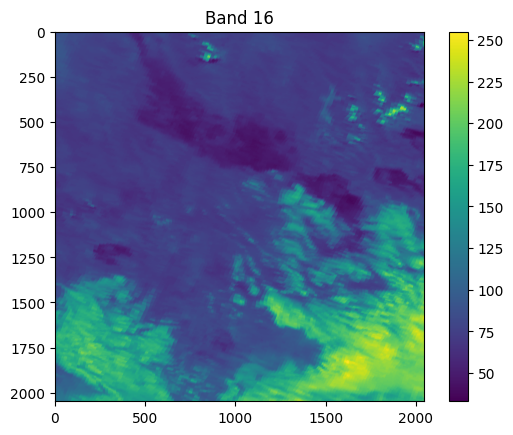

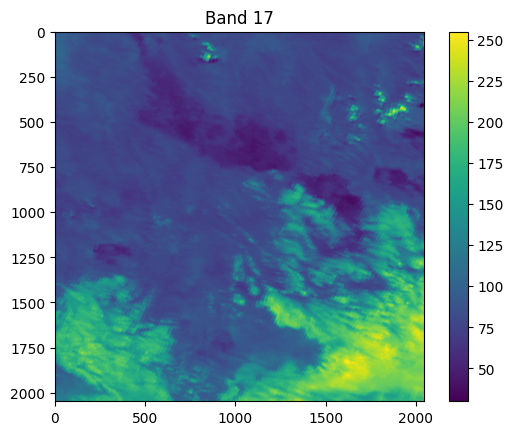

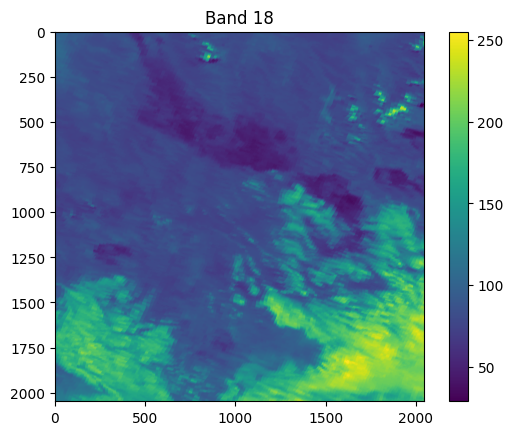

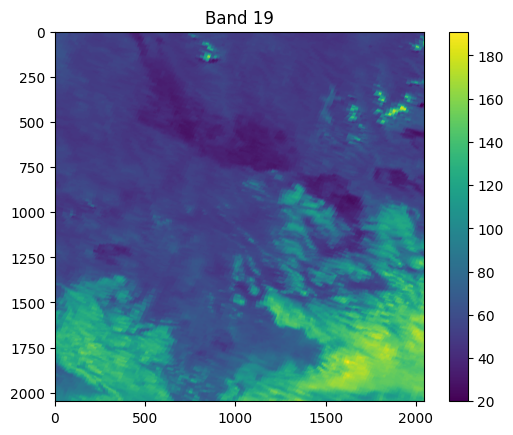

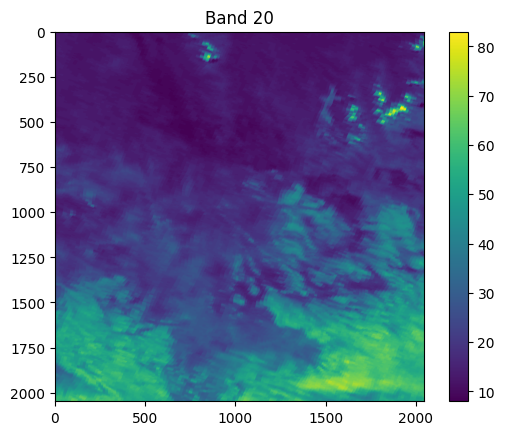

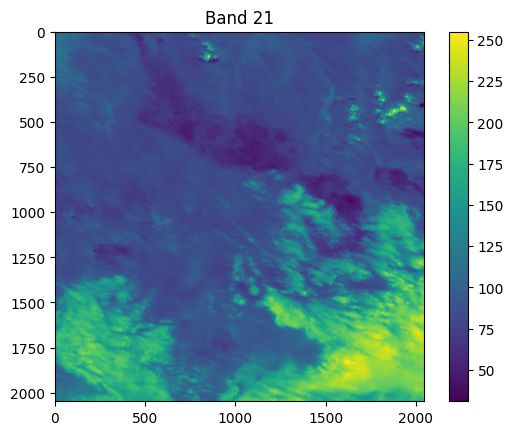

In [112]:
# show tiff image
import rasterio
import matplotlib.pyplot as plt
import numpy as np

tif_img = '/Users/taylortang/Life-at-UniMelb/Semester_4/COMP90055_Research/sentinelhub-py/examples/satellite_images/s3_olci_all_bands/bbox_87/2020-01-06_to_2020-01-07.tiff'

# Open the TIFF file
with rasterio.open(tif_img) as src:
    # Read bands B04 (red), B03 (green), B02 (blue)
    width, height = src.width, src.height
    bands = src.count
    dtype = src.dtypes[0]  # Assuming all bands have the same data type
    crs = src.crs
    transform = src.transform
    
    print(f"Width: {width}")
    print(f"Height: {height}")
    print(f"Number of Bands: {bands}")
    print(f"Data Type: {dtype}")
    print(f"Coordinate Reference System (CRS): {crs}")
    print(f"Transform: {transform}")

    # Loop through each band in the TIFF file
    for idx in range(src.count):
        band = src.read(idx + 1)
        
        plt.imshow(band)
        plt.colorbar()
        plt.title(f'Band {idx + 1}')
        plt.show()


['2020-01-06_to_2020-01-07.tiff', '2020-01-05_to_2020-01-06.tiff', '2020-01-07_to_2020-01-08.tiff', '2020-01-04_to_2020-01-05.tiff', '2020-01-02_to_2020-01-03.tiff', '2020-01-01_to_2020-01-02.tiff', '2019-12-31_to_2020-01-01.tiff', '2019-12-30_to_2019-12-31.tiff', '2020-01-08_to_2020-01-09.tiff', '2020-01-09_to_2020-01-10.tiff', '2020-01-03_to_2020-01-04.tiff']


/opt/homebrew/anaconda3/envs/mps/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


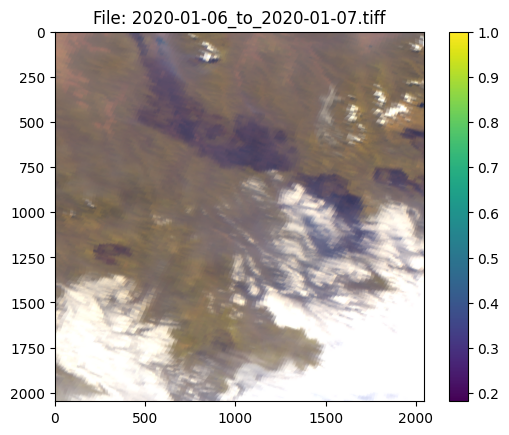

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


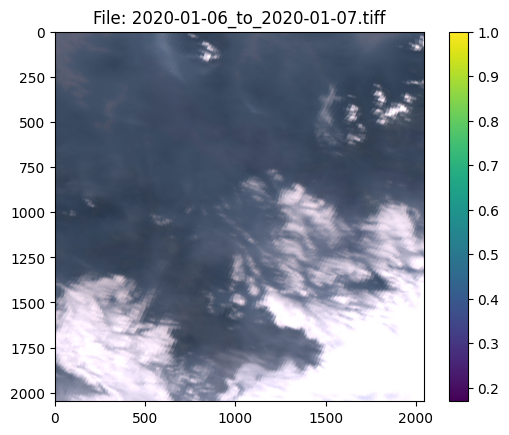

In [151]:
tif_img_folder = '/Users/taylortang/Life-at-UniMelb/Semester_4/COMP90055_Research/sentinelhub-py/examples/satellite_images/s3_olci_all_bands/bbox_87/'

all_files = os.listdir(tif_img_folder)

# show all img s3 olci tiff files with rgb band
print(all_files)

for file in all_files:
    with rasterio.open(tif_img_folder + file) as src:
        # Read bands B04 (red), B03 (green), B02 (blue)
        band_red = src.read(21)
        band_green = src.read(12)
        band_blue = src.read(4)
        
        band_rgb = np.dstack((band_red, band_green, band_blue))

        # Assuming the bands might have values that exceed 1, you might want to normalize:
        band_rgb = band_rgb / band_rgb.max() # This is just a basic normalization, there are more robust methods
        
        plt.imshow(band_rgb*1.5)
        plt.colorbar()
        plt.title(f'File: {file}')
        plt.show()

        # Read bands B04 (red), B03 (green), B02 (blue)
        band_red = src.read(8)
        band_green = src.read(6)
        band_blue = src.read(4)
        
        band_rgb = np.dstack((band_red, band_green, band_blue))

        # Assuming the bands might have values that exceed 1, you might want to normalize:
        band_rgb = band_rgb / band_rgb.max() # This is just a basic normalization, there are more robust methods
        
        plt.imshow(band_rgb*1.5)
        plt.colorbar()
        plt.title(f'File: {file}')
        plt.show()

        break